In [122]:
import pandas as pd

In [123]:
df = pd.read_csv('sinta_authors_cleaned.csv')
df

,sinta_score_overall,sinta_score_3yr,affil_score_overall,affil_score_3yr,bidang_count,program_studi_ord
0,458.0,252.0,458,252,4,2
1,951.0,500.0,1070,565,4,1
2,478.0,150.0,478,150,3,2
3,181.0,122.0,181,122,1,2
4,780.0,336.0,780,336,4,2
...,...,...,...,...,...,...
772,372.0,132.0,372,132,3,2
773,104.0,25.0,104,25,2,2
774,372.0,205.0,374,206,3,2
775,317.0,75.0,317,75,4,2


# OLS Regression

In [124]:
import statsmodels.api as sm

X = df[["sinta_score_3yr", "affil_score_overall", "affil_score_3yr", "bidang_count", "program_studi_ord"]]
y = df["sinta_score_overall"]

X = sm.add_constant(X)  # add intercept
model = sm.OLS(y, X).fit()

# print summary
print(model.summary())

# explicitly print model stats
print("\n--- Additional Fit Statistics ---")
print("AIC:", model.aic)
print("BIC:", model.bic)
print("R²:", model.rsquared)
print("Adj. R²:", model.rsquared_adj)


                             OLS Regression Results                            
Dep. Variable:     sinta_score_overall   R-squared:                       0.948
Model:                             OLS   Adj. R-squared:                  0.948
Method:                  Least Squares   F-statistic:                     2809.
Date:                 Mon, 29 Sep 2025   Prob (F-statistic):               0.00
Time:                         13:19:39   Log-Likelihood:                -4264.6
No. Observations:                  777   AIC:                             8541.
Df Residuals:                      771   BIC:                             8569.
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -

In [125]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# predictors & target
X = df[["sinta_score_3yr", "affil_score_overall", "affil_score_3yr", "bidang_count", "program_studi_ord"]]
y = df["sinta_score_overall"]

# standardize predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# put back into DataFrame (optional, just for readable summary)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# add intercept
X_scaled = sm.add_constant(X_scaled)

# fit OLS
model_scaled = sm.OLS(y, X_scaled).fit()

# print summary
print(model_scaled.summary())

# explicitly print model stats
print("\n--- Additional Fit Statistics ---")
print("AIC:", model_scaled.aic)
print("BIC:", model_scaled.bic)
print("R²:", model_scaled.rsquared)
print("Adj. R²:", model_scaled.rsquared_adj)


                             OLS Regression Results                            
Dep. Variable:     sinta_score_overall   R-squared:                       0.948
Model:                             OLS   Adj. R-squared:                  0.948
Method:                  Least Squares   F-statistic:                     2809.
Date:                 Mon, 29 Sep 2025   Prob (F-statistic):               0.00
Time:                         13:19:39   Log-Likelihood:                -4264.6
No. Observations:                  777   AIC:                             8541.
Df Residuals:                      771   BIC:                             8569.
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 40

Jarque-Bera stat: 118375.27354967188 p-value: 0.0
Skewness: 4.483185425904021
Kurtosis: 59.799525913916895


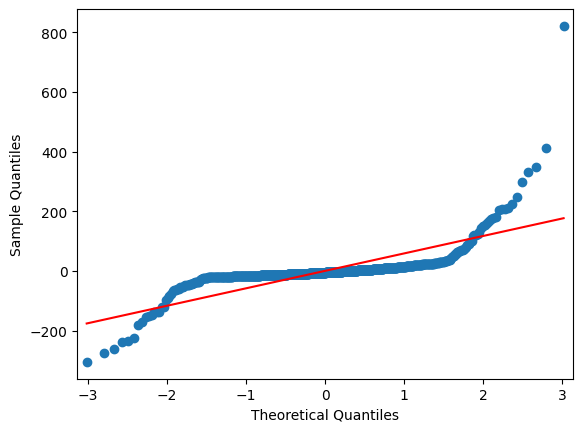

In [126]:
from scipy.stats import jarque_bera, skew, kurtosis
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Jarque–Bera test
jb_stat, jb_p = jarque_bera(model.resid)
print("Jarque-Bera stat:", jb_stat, "p-value:", jb_p)

# Skewness & Kurtosis
print("Skewness:", skew(model.resid))
print("Kurtosis:", kurtosis(model.resid))

# Q-Q plot
sm.qqplot(model.resid, line="s")
plt.show()


In [127]:
from statsmodels.stats.diagnostic import het_breuschpagan

bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ["LM stat", "LM p-value", "F stat", "F p-value"]
print(dict(zip(labels, bp_test)))


{'LM stat': np.float64(5.440290601897738), 'LM p-value': np.float64(0.36453766371472723), 'F stat': np.float64(1.0872688148361858), 'F p-value': np.float64(0.3659286085061403)}


In [128]:
from statsmodels.stats.stattools import durbin_watson

dw = durbin_watson(model.resid)
print("Durbin-Watson:", dw)


Durbin-Watson: 2.0359362450964293


In [129]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

vif = pd.DataFrame()
vif["Variable"] = X_sel.columns
vif["VIF"] = [variance_inflation_factor(X_sel.values, i) for i in range(X_sel.shape[1])]
print(vif)


              Variable        VIF
0                const  11.206366
1  affil_score_overall   2.756391
2      sinta_score_3yr   5.748923
3      affil_score_3yr   8.048530
4    program_studi_ord   1.012371


# Stepwise Regression

In [130]:
import statsmodels.api as sm

def stepwise_selection_aic(X, y, 
                           initial_list=[], 
                           verbose=True):
    """Perform forward-backward feature selection based on AIC."""
    included = list(initial_list)
    best_aic = float("inf")
    while True:
        changed = False

        # forward step
        excluded = list(set(X.columns) - set(included))
        new_aic = {}
        for new_col in excluded:
            model = sm.OLS(y, sm.add_constant(X[included + [new_col]])).fit()
            new_aic[new_col] = model.aic
        if new_aic:
            best_new_feature = min(new_aic, key=new_aic.get)
            if new_aic[best_new_feature] < best_aic:
                included.append(best_new_feature)
                best_aic = new_aic[best_new_feature]
                changed = True
                if verbose:
                    print(f"Add  {best_new_feature:20} AIC={best_aic:.3f}")

        # backward step
        if len(included) > 0:
            aic_with_feature = {}
            for col in included:
                cols = list(set(included) - {col})
                if cols:
                    model = sm.OLS(y, sm.add_constant(X[cols])).fit()
                    aic_with_feature[col] = model.aic
            if aic_with_feature:
                worst_feature = min(aic_with_feature, key=aic_with_feature.get)
                if aic_with_feature[worst_feature] < best_aic:
                    included.remove(worst_feature)
                    best_aic = aic_with_feature[worst_feature]
                    changed = True
                    if verbose:
                        print(f"Drop {worst_feature:20} AIC={best_aic:.3f}")

        if not changed:
            break

    return included, best_aic


In [131]:
X = df[["sinta_score_3yr", "affil_score_overall", "affil_score_3yr", "bidang_count", "program_studi_ord"]]
y = df["sinta_score_overall"]

selected_features, final_aic = stepwise_selection_aic(X, y)
print("Selected features:", selected_features)
print("Final AIC:", final_aic)


Add  affil_score_overall  AIC=9537.169
Add  sinta_score_3yr      AIC=9332.836
Add  affil_score_3yr      AIC=8543.994
Add  program_studi_ord    AIC=8540.068
Selected features: ['affil_score_overall', 'sinta_score_3yr', 'affil_score_3yr', 'program_studi_ord']
Final AIC: 8540.068242322232


In [132]:
# fit OLS on selected features
X_sel = sm.add_constant(X[selected_features])
model_sel = sm.OLS(y, X_sel).fit()

print("Selected features:", selected_features)
print("Final AIC (stepwise):", final_aic)
print(model_sel.summary())

# extra stats
print("\n--- Additional Fit Statistics ---")
print("AIC (model):", model_sel.aic)
print("BIC:", model_sel.bic)
print("R²:", model_sel.rsquared)
print("Adj. R²:", model_sel.rsquared_adj)


Selected features: ['affil_score_overall', 'sinta_score_3yr', 'affil_score_3yr', 'program_studi_ord']
Final AIC (stepwise): 8540.068242322232
                             OLS Regression Results                            
Dep. Variable:     sinta_score_overall   R-squared:                       0.948
Model:                             OLS   Adj. R-squared:                  0.948
Method:                  Least Squares   F-statistic:                     3511.
Date:                 Mon, 29 Sep 2025   Prob (F-statistic):               0.00
Time:                         13:19:39   Log-Likelihood:                -4265.0
No. Observations:                  777   AIC:                             8540.
Df Residuals:                      772   BIC:                             8563.
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      

In [133]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import pandas as pd

# scale only the selected features
scaler = StandardScaler()
X_sel_scaled = scaler.fit_transform(X[selected_features])

# wrap back into DataFrame for readability
X_sel_scaled = pd.DataFrame(X_sel_scaled, columns=selected_features, index=X.index)

# add intercept
X_sel_scaled = sm.add_constant(X_sel_scaled)

# fit OLS
model_sel_scaled = sm.OLS(y, X_sel_scaled).fit()

print("Selected features (scaled):", selected_features)
print("Final AIC (stepwise):", final_aic)  # still from raw stepwise
print(model_sel_scaled.summary())

# extra stats
print("\n--- Additional Fit Statistics ---")
print("AIC (model):", model_sel_scaled.aic)
print("BIC:", model_sel_scaled.bic)
print("R²:", model_sel_scaled.rsquared)
print("Adj. R²:", model_sel_scaled.rsquared_adj)


Selected features (scaled): ['affil_score_overall', 'sinta_score_3yr', 'affil_score_3yr', 'program_studi_ord']
Final AIC (stepwise): 8540.068242322232
                             OLS Regression Results                            
Dep. Variable:     sinta_score_overall   R-squared:                       0.948
Model:                             OLS   Adj. R-squared:                  0.948
Method:                  Least Squares   F-statistic:                     3511.
Date:                 Mon, 29 Sep 2025   Prob (F-statistic):               0.00
Time:                         13:19:39   Log-Likelihood:                -4265.0
No. Observations:                  777   AIC:                             8540.
Df Residuals:                      772   BIC:                             8563.
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                          coef    std err        

Jarque-Bera stat: 120110.5148084902 p-value: 0.0
Skewness: 4.491036070634315
Kurtosis: 60.243669139843924


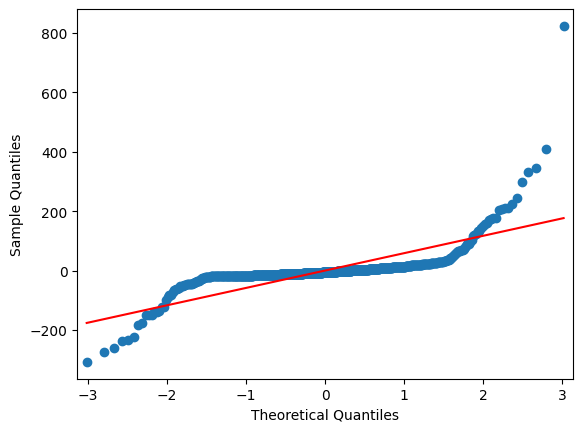

In [134]:
from scipy.stats import jarque_bera, skew, kurtosis
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Jarque–Bera test
jb_stat, jb_p = jarque_bera(model_sel.resid)
print("Jarque-Bera stat:", jb_stat, "p-value:", jb_p)

# Skewness & Kurtosis
print("Skewness:", skew(model_sel.resid))
print("Kurtosis:", kurtosis(model_sel.resid))

# Q-Q plot
sm.qqplot(model_sel.resid, line="s")
plt.show()


In [135]:
from statsmodels.stats.diagnostic import het_breuschpagan

bp_test = het_breuschpagan(model_sel.resid, model_sel.model.exog)
labels = ["LM stat", "LM p-value", "F stat", "F p-value"]
print(dict(zip(labels, bp_test)))


{'LM stat': np.float64(5.100701814892055), 'LM p-value': np.float64(0.27712005318825605), 'F stat': np.float64(1.2753418128359189), 'F p-value': np.float64(0.2780706939542902)}


In [136]:
from statsmodels.stats.stattools import durbin_watson

dw = durbin_watson(model_sel.resid)
print("Durbin-Watson:", dw)


Durbin-Watson: 2.0309204951094526


In [137]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

vif = pd.DataFrame()
vif["Variable"] = X_sel.columns
vif["VIF"] = [variance_inflation_factor(X_sel.values, i) for i in range(X_sel.shape[1])]
print(vif)


              Variable        VIF
0                const  11.206366
1  affil_score_overall   2.756391
2      sinta_score_3yr   5.748923
3      affil_score_3yr   8.048530
4    program_studi_ord   1.012371


# LASSO & Ridge Regression

In [138]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import statsmodels.api as sm
import pandas as pd

# predictors & target
X = df[["sinta_score_3yr", "affil_score_overall", "affil_score_3yr", "bidang_count", "program_studi_ord"]]
y = df["sinta_score_overall"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [139]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error

# scale predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# fit LassoCV with a wider alpha grid
alphas = np.logspace(-4, 4, 200)
lasso_cv = LassoCV(alphas=alphas, cv=10, random_state=1618, n_jobs=-1).fit(X_scaled, y)
y_pred_lasso = lasso_cv.predict(X_scaled)

# --- Coefficients on standardized scale ---
coef_lasso_scaled = pd.Series(lasso_cv.coef_, index=X.columns)
intercept_scaled = lasso_cv.intercept_

# --- Transform back to original scale ---
coef_lasso_original = lasso_cv.coef_ / scaler.scale_
intercept_lasso_original = y.mean() - (coef_lasso_original * X.mean()).sum()
coef_lasso_original = pd.Series(coef_lasso_original, index=X.columns)

# metrics
n, k = X.shape
rss = np.sum((y - y_pred_lasso) ** 2)
r2 = r2_score(y, y_pred_lasso)
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
aic = n * np.log(rss / n) + 2 * (k + 1)
bic = n * np.log(rss / n) + np.log(n) * (k + 1)
mape = mean_absolute_percentage_error(y, y_pred_lasso)
rmse = np.sqrt(mean_squared_error(y, y_pred_lasso))

# results
print("\n--- LassoCV Results ---")
print("Best alpha:", lasso_cv.alpha_)
print("R²:", r2)
print("Adj. R²:", adj_r2)
print("AIC:", aic)
print("BIC:", bic)
print("MAPE:", mape)
print("RMSE:", rmse)

print("\nCoefficients (standardized scale):")
print("Intercept:", intercept_scaled)
print(coef_lasso_scaled)

print("\nCoefficients (original scale):")
print("Intercept:", intercept_lasso_original)
print(coef_lasso_original)



--- LassoCV Results ---
Best alpha: 0.499450511585514
R²: 0.9478264092472699
Adj. R²: 0.9474880591126867
AIC: 6338.108988527168
BIC: 6366.041630629374
MAPE: 0.11759439147467157
RMSE: 58.6070622171426

Coefficients (standardized scale):
Intercept: 402.1415701415702
sinta_score_3yr        220.772700
affil_score_overall    244.797602
affil_score_3yr       -212.115213
bidang_count             1.974969
program_studi_ord        4.744228
dtype: float64

Coefficients (original scale):
Intercept: 1.133201176163709
sinta_score_3yr        1.805598
affil_score_overall    0.921833
affil_score_3yr       -1.713281
bidang_count           1.517750
program_studi_ord      7.417558
dtype: float64


In [140]:
import numpy as np
import pandas as pd
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error

# fit RidgeCV with multiple alphas
ridge_cv = RidgeCV(alphas=np.logspace(-4, 4, 200), cv=10).fit(X_scaled, y)
y_pred_ridge = ridge_cv.predict(X_scaled)

# --- Coefficients on standardized scale ---
coef_ridge_scaled = pd.Series(ridge_cv.coef_, index=X.columns)
intercept_scaled = ridge_cv.intercept_

# --- Transform back to original scale ---
coef_ridge_original = ridge_cv.coef_ / scaler.scale_
intercept_ridge_original = y.mean() - (coef_ridge_original * X.mean()).sum()
coef_ridge_original = pd.Series(coef_ridge_original, index=X.columns)

# metrics
n, k = X.shape
rss = np.sum((y - y_pred_ridge) ** 2)
r2 = r2_score(y, y_pred_ridge)
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
aic = n * np.log(rss / n) + 2 * (k + 1)
bic = n * np.log(rss / n) + np.log(n) * (k + 1)
mape = mean_absolute_percentage_error(y, y_pred_ridge)
rmse = np.sqrt(mean_squared_error(y, y_pred_ridge))

# results
print("\n--- RidgeCV Results ---")
print("Best alpha:", ridge_cv.alpha_)
print("R²:", r2)
print("Adj. R²:", adj_r2)
print("AIC:", aic)
print("BIC:", bic)
print("MAPE:", mape)
print("RMSE:", rmse)

print("\nCoefficients (standardized scale):")
print("Intercept:", intercept_scaled)
print(coef_ridge_scaled)

print("\nCoefficients (original scale):")
print("Intercept:", intercept_ridge_original)
print(coef_ridge_original)



--- RidgeCV Results ---
Best alpha: 2.0022003718155843
R²: 0.9477913651445147
Adj. R²: 0.9474527877459706
AIC: 6338.630710854989
BIC: 6366.563352957195
MAPE: 0.11904266714187552
RMSE: 58.62674159051696

Coefficients (standardized scale):
Intercept: 402.1415701415702
sinta_score_3yr        219.920827
affil_score_overall    244.210888
affil_score_3yr       -210.915189
bidang_count             2.523788
program_studi_ord        5.242997
dtype: float64

Coefficients (original scale):
Intercept: -1.2726920388954
sinta_score_3yr        1.798630
affil_score_overall    0.919624
affil_score_3yr       -1.703589
bidang_count           1.939513
program_studi_ord      8.197378
dtype: float64



--- LassoCV Residual Diagnostics ---
Jarque-Bera stat: 116408.59805460252 p-value: 0.0
Breusch-Pagan: {'LM stat': np.float64(5.608046249911279), 'LM p-value': np.float64(0.34624361038972606), 'F stat': np.float64(1.1210393465116215), 'F p-value': np.float64(0.3475585059901893)}
Durbin-Watson: 2.036497969295969


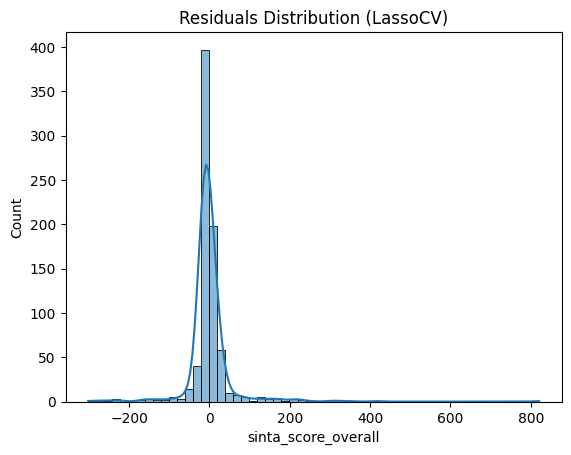


--- RidgeCV Residual Diagnostics ---
Jarque-Bera stat: 114947.37561871627 p-value: 0.0
Breusch-Pagan: {'LM stat': np.float64(5.642715203712113), 'LM p-value': np.float64(0.342550250078781), 'F stat': np.float64(1.1280203111612452), 'F p-value': np.float64(0.3438491963910635)}
Durbin-Watson: 2.0394335161305945


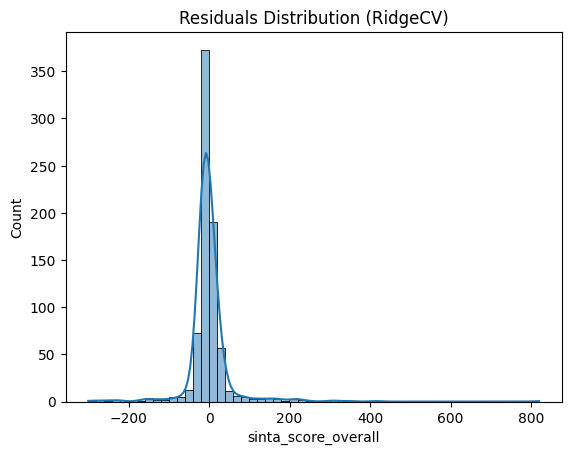

In [141]:
from scipy.stats import jarque_bera
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
import seaborn as sns
import matplotlib.pyplot as plt

def check_assumptions(y_true, y_pred, X_scaled, model_name="Model"):
    resid = y_true - y_pred
    print(f"\n--- {model_name} Residual Diagnostics ---")

    # Normality
    jb_stat, jb_p = jarque_bera(resid)
    print("Jarque-Bera stat:", jb_stat, "p-value:", jb_p)

    # Homoscedasticity
    X_with_const = sm.add_constant(X_scaled, has_constant="add")
    bp_test = het_breuschpagan(resid, X_with_const)
    labels = ["LM stat", "LM p-value", "F stat", "F p-value"]
    print("Breusch-Pagan:", dict(zip(labels, bp_test)))

    # Autocorrelation
    print("Durbin-Watson:", durbin_watson(resid))

    # Residual plot
    sns.histplot(resid, kde=True)
    plt.title(f"Residuals Distribution ({model_name})")
    plt.show()

# check for both
check_assumptions(y, y_pred_lasso, X_scaled, "LassoCV")
check_assumptions(y, y_pred_ridge, X_scaled, "RidgeCV")


# Final Comparison

In [142]:
# --- Original scale coefficients ---
coef_orig = pd.DataFrame({
    "OLS (orig)": model.params,
    "Stepwise (orig)": model_sel.params,
    "Lasso (orig)": pd.Series([intercept_lasso_original] + list(coef_lasso_original),
                               index=["const"] + list(X.columns)),
    "Ridge (orig)": pd.Series([intercept_ridge_original] + list(coef_ridge_original),
                               index=["const"] + list(X.columns))
})

# --- Standardized scale coefficients ---
coef_std = pd.DataFrame({
    "OLS (std)": model_scaled.params,
    "Stepwise (std)": model_sel_scaled.params,
    "Lasso (std)": pd.Series([lasso_cv.intercept_] + list(lasso_cv.coef_),
                              index=["const"] + list(X.columns)),
    "Ridge (std)": pd.Series([ridge_cv.intercept_] + list(ridge_cv.coef_),
                              index=["const"] + list(X.columns))
})

print("\n--- Coefficients (Original Scale) ---")
display(coef_orig)

print("\n--- Coefficients (Standardized Scale) ---")
display(coef_std)



--- Coefficients (Original Scale) ---


,OLS (orig),Stepwise (orig),Lasso (orig),Ridge (orig)
affil_score_3yr,-1.778548,-1.784026,-1.713281,-1.703589
affil_score_overall,0.932408,0.933130,0.921833,0.919624
bidang_count,1.563240,NaN,1.517750,1.939513
const,-1.611377,2.896101,1.133201,-1.272692
program_studi_ord,7.944632,8.061287,7.417558,8.197378
sinta_score_3yr,1.853641,1.860469,1.805598,1.798630



--- Coefficients (Standardized Scale) ---


,OLS (std),Stepwise (std),Lasso (std),Ridge (std)
affil_score_3yr,-220.195680,-220.873809,-212.115213,-210.915189
affil_score_overall,247.605745,247.797476,244.797602,244.210888
bidang_count,2.034163,NaN,1.974969,2.523788
const,402.141570,402.141570,402.141570,402.141570
program_studi_ord,5.081341,5.155954,4.744228,5.242997
sinta_score_3yr,226.647021,227.481917,220.772700,219.920827


In [144]:
# --- Collect metrics function ---
def collect_metrics(model, X, y, name="Model"):
    n, k = X.shape
    y_pred = model.fittedvalues if hasattr(model, "fittedvalues") else model.predict(X)
    rss = np.sum((y - y_pred) ** 2)
    r2 = r2_score(y, y_pred)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
    aic = n * np.log(rss / n) + 2 * (k + 1)
    bic = n * np.log(rss / n) + np.log(n) * (k + 1)
    return pd.Series({"AIC": aic, "BIC": bic, "R²": r2, "Adj. R²": adj_r2}, name=name)

# --- Original scale models ---
metrics_orig = pd.DataFrame([
    collect_metrics(model, X, y, "OLS (orig)"),
    collect_metrics(model_sel, sm.add_constant(X[selected_features]), y, "Stepwise (orig)"),
    collect_metrics(lasso_cv, X_scaled, y, "Lasso (orig)"),   # use X_scaled but coeffs backtransformed
    collect_metrics(ridge_cv, X_scaled, y, "Ridge (orig)")
])

# --- Standardized scale models ---
metrics_std = pd.DataFrame([
    collect_metrics(model_scaled, sm.add_constant(X_scaled), y, "OLS (std)"),
    collect_metrics(model_sel_scaled, sm.add_constant(X_sel_scaled[selected_features]), y, "Stepwise (std)"),
    collect_metrics(lasso_cv, X_scaled, y, "Lasso (std)"),
    collect_metrics(ridge_cv, X_scaled, y, "Ridge (std)")
])

print("\n--- Model Fit (Original Scale) ---")
display(metrics_orig)

print("\n--- Model Fit (Standardized Scale) ---")
display(metrics_std)



--- Model Fit (Original Scale) ---


,AIC,BIC,R²,Adj. R²
OLS (orig),6336.143068,6364.075711,0.947958,0.947621
Stepwise (orig),6337.037762,6364.970404,0.947898,0.947560
Lasso (orig),6338.108989,6366.041631,0.947826,0.947488
Ridge (orig),6338.630711,6366.563353,0.947791,0.947453



--- Model Fit (Standardized Scale) ---


,AIC,BIC,R²,Adj. R²
OLS (std),6338.143068,6370.731151,0.947958,0.947553
Stepwise (std),6337.037762,6364.970404,0.947898,0.947560
Lasso (std),6338.108989,6366.041631,0.947826,0.947488
Ridge (std),6338.630711,6366.563353,0.947791,0.947453
